# Customer Feedback NLP & Predictive Modeling

This notebook builds an end-to-end NLP pipeline to:

- Clean and preprocess customer comments
- Perform topic modeling (LDA)
- Train word embeddings (Word2Vec)
- Integrate text-derived features with structured variables
- Train and evaluate decision tree classifiers

## Import  Dependencies

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Gensim (Topic Modeling & Embeddings)
import gensim
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.matutils import corpus2csc

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
from sklearn import tree

# Ensure NLTK resources are available
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qusai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import Data

In [2]:
gasQ = pd.read_csv(
    "https://raw.githubusercontent.com/qfattah/customer-comment-nlp-classification/main/gastext.csv",
    encoding="ISO-8859-1"
)

In [3]:
# Inspect data
gasQ.head()

,Cust_ID,Comment,Target,Service_flag,CustType_flag,Contact_flag,new_flag,Choice_flag,Loyal_Status,Comp_card_flag,AcctType_flag,Contact_Flag2,HQ_flag,Multi_flag,NewCust_Flag
0,1,prices ...,1,2,2,1,2,1,1,0,0,0,0,0,0
1,10,"clean shower and restroom, easy in and out ...",1,1,1,1,2,1,1,0,0,0,0,0,0
2,100,productx price and rewards ...,0,1,2,2,2,1,1,0,0,0,0,0,0
3,102,food ...,0,2,2,1,1,1,1,0,0,0,0,0,0
4,103,not real busy ...,0,2,2,1,2,1,1,0,0,0,0,0,1


In [4]:
# Function to calculate vocabulary size
def calculate_vocab_size(series):
    vocab = set(series.str.split().explode().values)
    print(f"{len(vocab)} unique terms in potential DFM.")

calculate_vocab_size(gasQ['Comment'])

1037 unique terms in potential DFM.


## Data Preprocessing

In [5]:
# Convert all words into lower cases

gasQ['Comment'] = gasQ['Comment'].str.lower()
calculate_vocab_size(gasQ['Comment'])

1015 unique terms in potential DFM.


In [6]:
# Remove stop words

stop_words = stopwords.words('english')

gasQ['Comment'] = gasQ['Comment'].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop_words)
)

In [7]:
# Remove Punctuation

gasQ['Comment'] = gasQ['Comment'].str.replace(r'[^\w\s]+', '', regex=True)

In [8]:
# Custom Stopword Adjustment

stop_words += ['no']

gasQ['Comment'] = gasQ['Comment'].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop_words)
)

In [9]:
# Stemming

stemmer = PorterStemmer()

gasQ['Comment'] = gasQ['Comment'].apply(
    lambda x: " ".join(stemmer.stem(word) for word in x.split())
)

## Exploratory Text Analysis

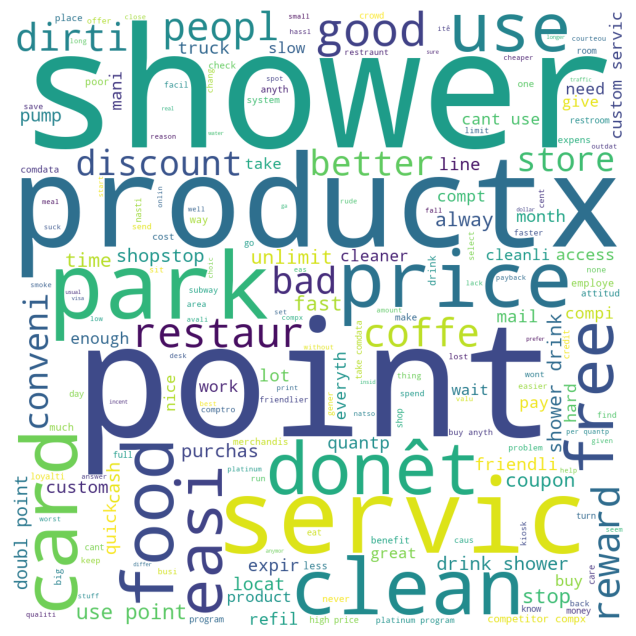

In [10]:
# Frequency analysis (Top 20 words)
# WordCloud visualization to identify dominant themes

text_blob = " ".join(gasQ['Comment'])

wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    width=1000,
    height=1000
).generate(text_blob)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Document-Term Matrix Construction

In [11]:
# Tokenize corpus
corpus = [doc.split() for doc in gasQ['Comment']]

# Create dictionary
dictionary = corpora.Dictionary(corpus)

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.75)

# Create Bag-of-Words representation
DFM = [dictionary.doc2bow(doc) for doc in corpus]


## Word Embeddings

In [12]:
# Word2Vec Embeddings

w2v_model = Word2Vec(
    corpus,
    min_count=20,
    vector_size=40,
    window=3,
    sg=1,
    workers=3
)

w2v_model.wv.most_similar('servic', topn=5)

[('free', 0.323390394449234),
 ('bad', 0.18875175714492798),
 ('get', 0.15277472138404846),
 ('price', 0.1146526113152504),
 ('card', 0.0688922181725502)]

## Topic Modeling (LDA)

In [13]:
lda_model = models.LdaModel(
    DFM,
    num_topics=3,
    id2word=dictionary,
    passes=40
)

print(lda_model.print_topics(num_words=8))

[(0, '0.134*"shower" + 0.059*"productx" + 0.051*"donêt" + 0.047*"drink" + 0.042*"free" + 0.039*"get" + 0.031*"point" + 0.026*"use"'), (1, '0.138*"point" + 0.069*"price" + 0.056*"use" + 0.056*"servic" + 0.052*"productx" + 0.047*"park" + 0.044*"food" + 0.040*"easi"'), (2, '0.062*"shower" + 0.060*"clean" + 0.048*"servic" + 0.047*"good" + 0.043*"dirti" + 0.030*"alway" + 0.026*"stop" + 0.026*"store"')]


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, DFM, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.112445  0.167788       1        1  36.807828
1     -0.219686  0.002671       2        1  36.663461
2      0.107241 -0.170459       3        1  26.528711, topic_info=        Term        Freq       Total Category  logprob  loglift
10    shower  122.000000  122.000000  Default  30.0000  30.0000
0      point  116.000000  116.000000  Default  29.0000  29.0000
1      price   47.000000   47.000000  Default  28.0000  28.0000
6      donêt   35.000000   35.000000  Default  27.0000  27.0000
27     drink   32.000000   32.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
18      park    9.039165   43.579086   Topic3  -3.9933  -0.2461
41       get    8.758531   51.801872   Topic3  -4.0249  -0.4505
16    custom    7.313264   20.896265   Topic3  -4.2052   0.2771
24     peopl    6.722359   22.602493   Topic3  -4.2895   0.1143
52  discount    6.465049   17.997812   Topic3  -4.3285   0.3031

[144 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.531514       1
3         2  0.531514       1
95        1  0.971974    1000
96        2  0.961890  access
67        3  0.977948   alway
...     ...       ...     ...
50        2  0.584422    wait
50        3  0.467538    wait
83        2  0.659351     way
83        3  0.263741     way
32        3  0.939292    work

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Predictive Modeling — Baseline (Structured Data Only)

In [15]:
# Remove text & ID
df_struct = gasQ.drop(['Cust_ID', 'Comment'], axis=1)

y = df_struct['Target']
X = df_struct.drop('Target', axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0
)

dtree = DecisionTreeClassifier(max_depth=4, min_samples_split=30)
dtree.fit(X_train, y_train)

print("Baseline Validation Accuracy:", dtree.score(X_val, y_val))

Baseline Validation Accuracy: 0.5517241379310345


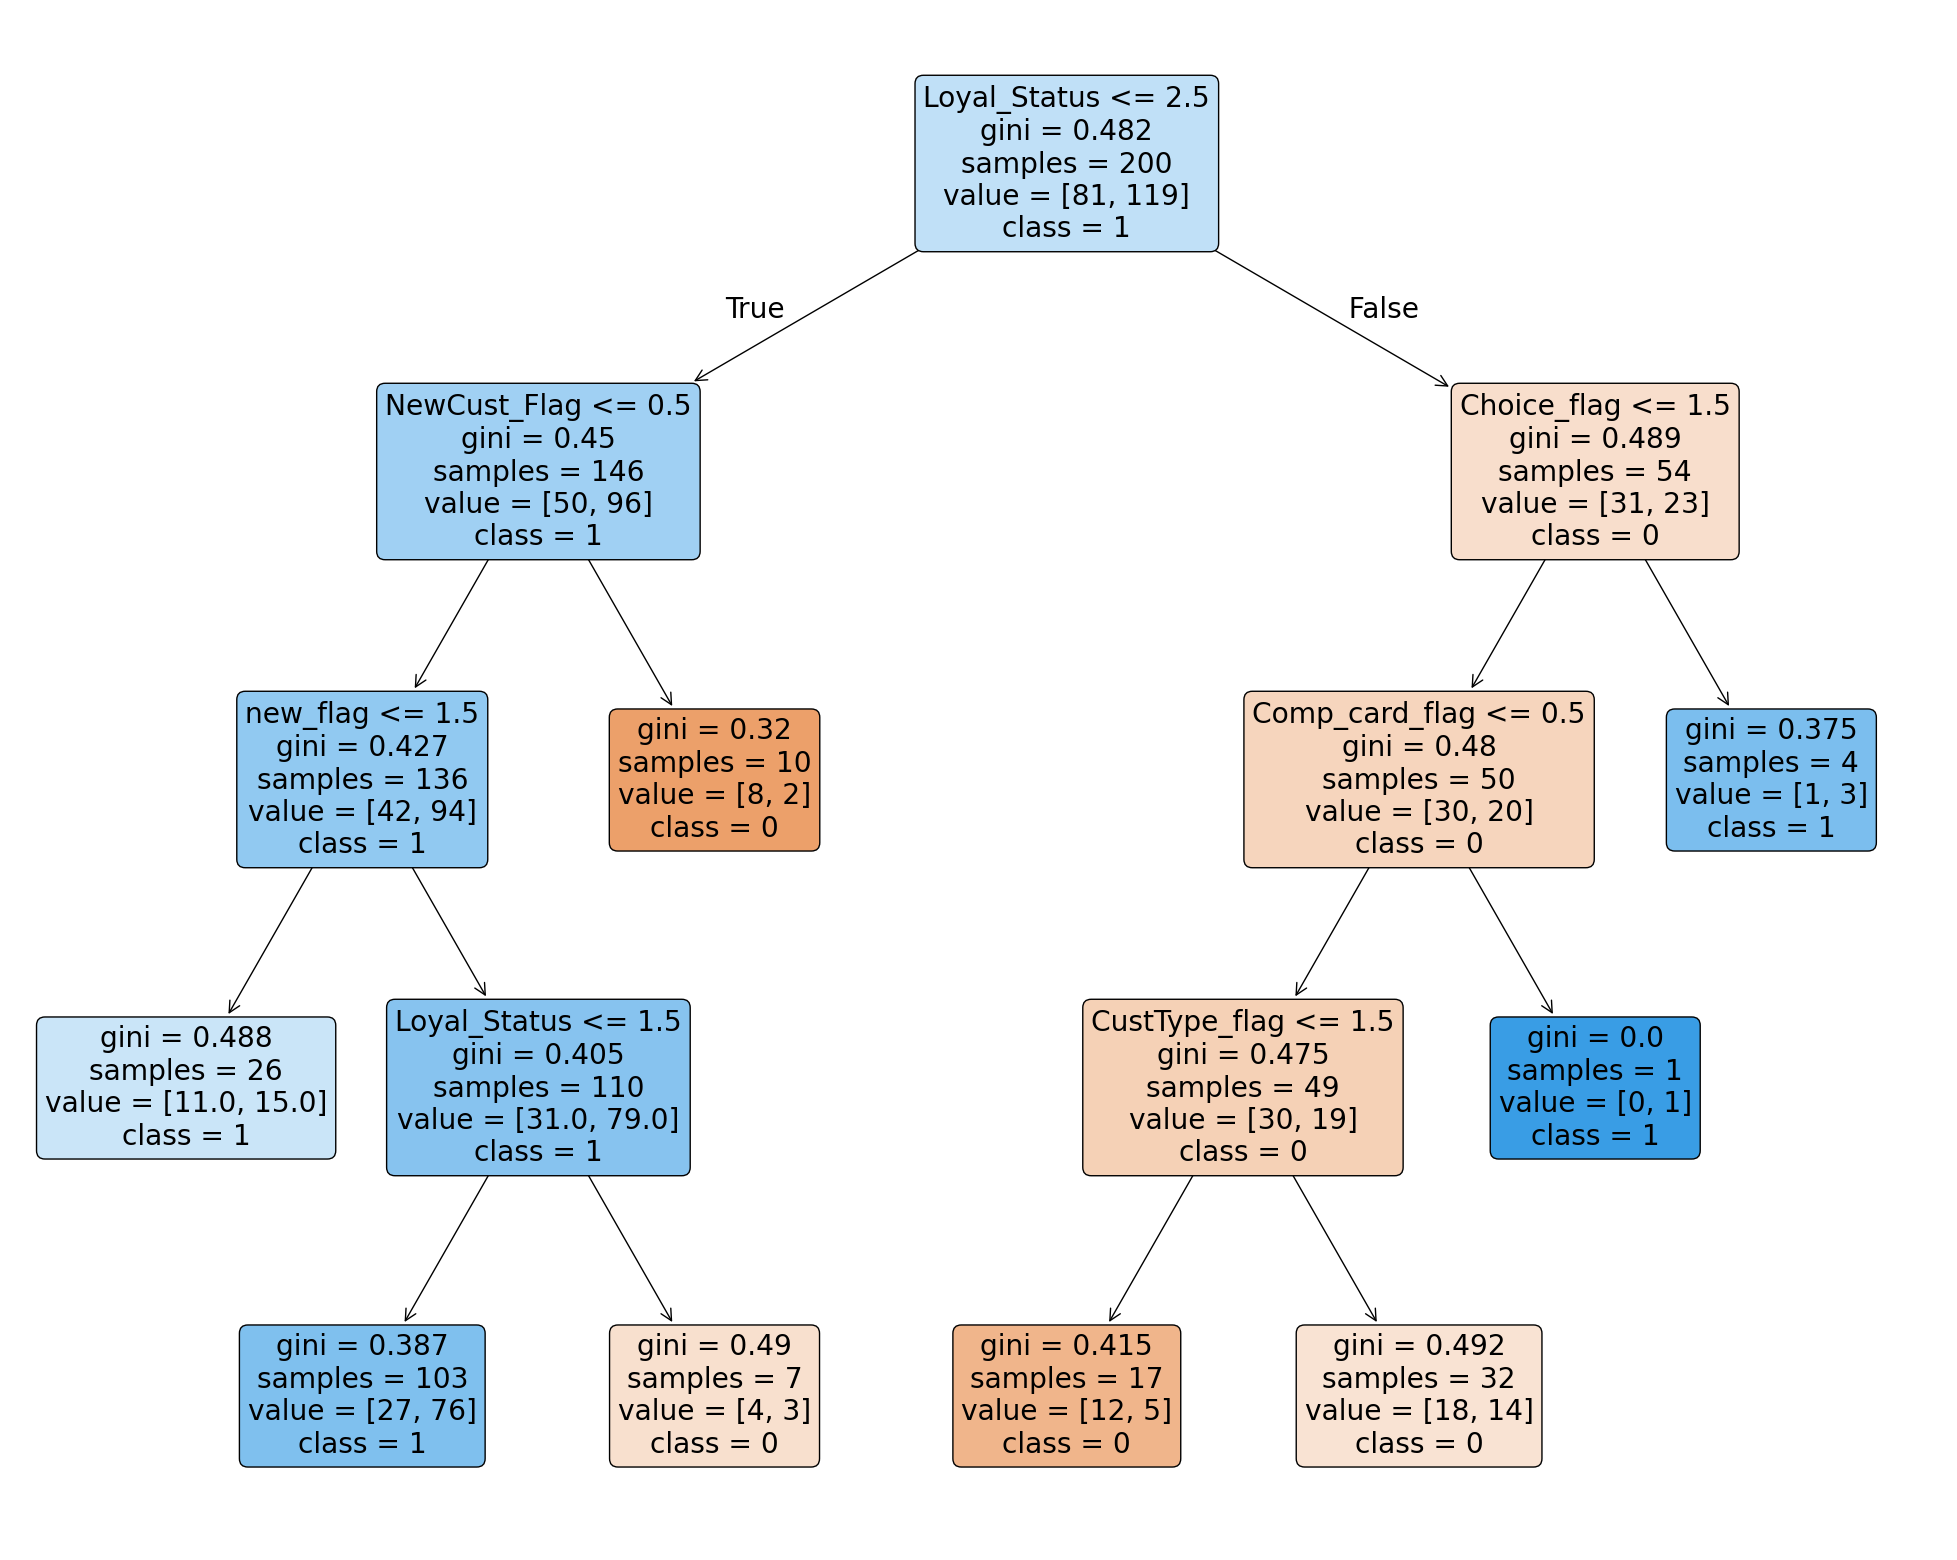

In [16]:
# Display decision tree results

plt.figure(figsize=(25, 20))
tree.plot_tree(
    dtree,
    feature_names=X_train.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.show()

### Baseline Decision Tree Validation Performance

The baseline Decision Tree model (using structured variables only) achieved a **validation accuracy of 55.17%**.

This modest performance suggests that structured numeric features alone provide limited predictive power. It highlights the potential value of incorporating text-derived features (e.g., TF-IDF, SVD components) to improve classification performance.

## Feature Engineering — TF-IDF + SVD

In [18]:
# TF-IDF
tfidf_model = models.TfidfModel(DFM)
DFM_tfidf = tfidf_model[DFM]

# SVD (LSI)
svd_model = models.LsiModel(
    DFM_tfidf,
    id2word=dictionary,
    num_topics=6
)

SVD = svd_model[DFM_tfidf]

svd_array = gensim.matutils.corpus2csc(SVD).T.toarray()

# Convert to dataframe
svd_df = pd.DataFrame(
    svd_array,
    columns=[f"SVD_{i+1}" for i in range(svd_array.shape[1])]
)

c:\Users\qusai\anaconda3\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(


## Hybrid Model (Structured + Text Features)

In [20]:
df_numeric = gasQ.drop(['Cust_ID', 'Comment', 'Target'], axis=1)

X2 = pd.concat([svd_df, df_numeric], axis=1)

X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2, y, test_size=0.3, random_state=0
)

dtree2 = DecisionTreeClassifier(max_depth=4, min_samples_split=30)
dtree2.fit(X2_train, y2_train)

print("Hybrid Model Validation Accuracy:", dtree2.score(X2_val, y2_val))

Hybrid Model Validation Accuracy: 0.5057471264367817


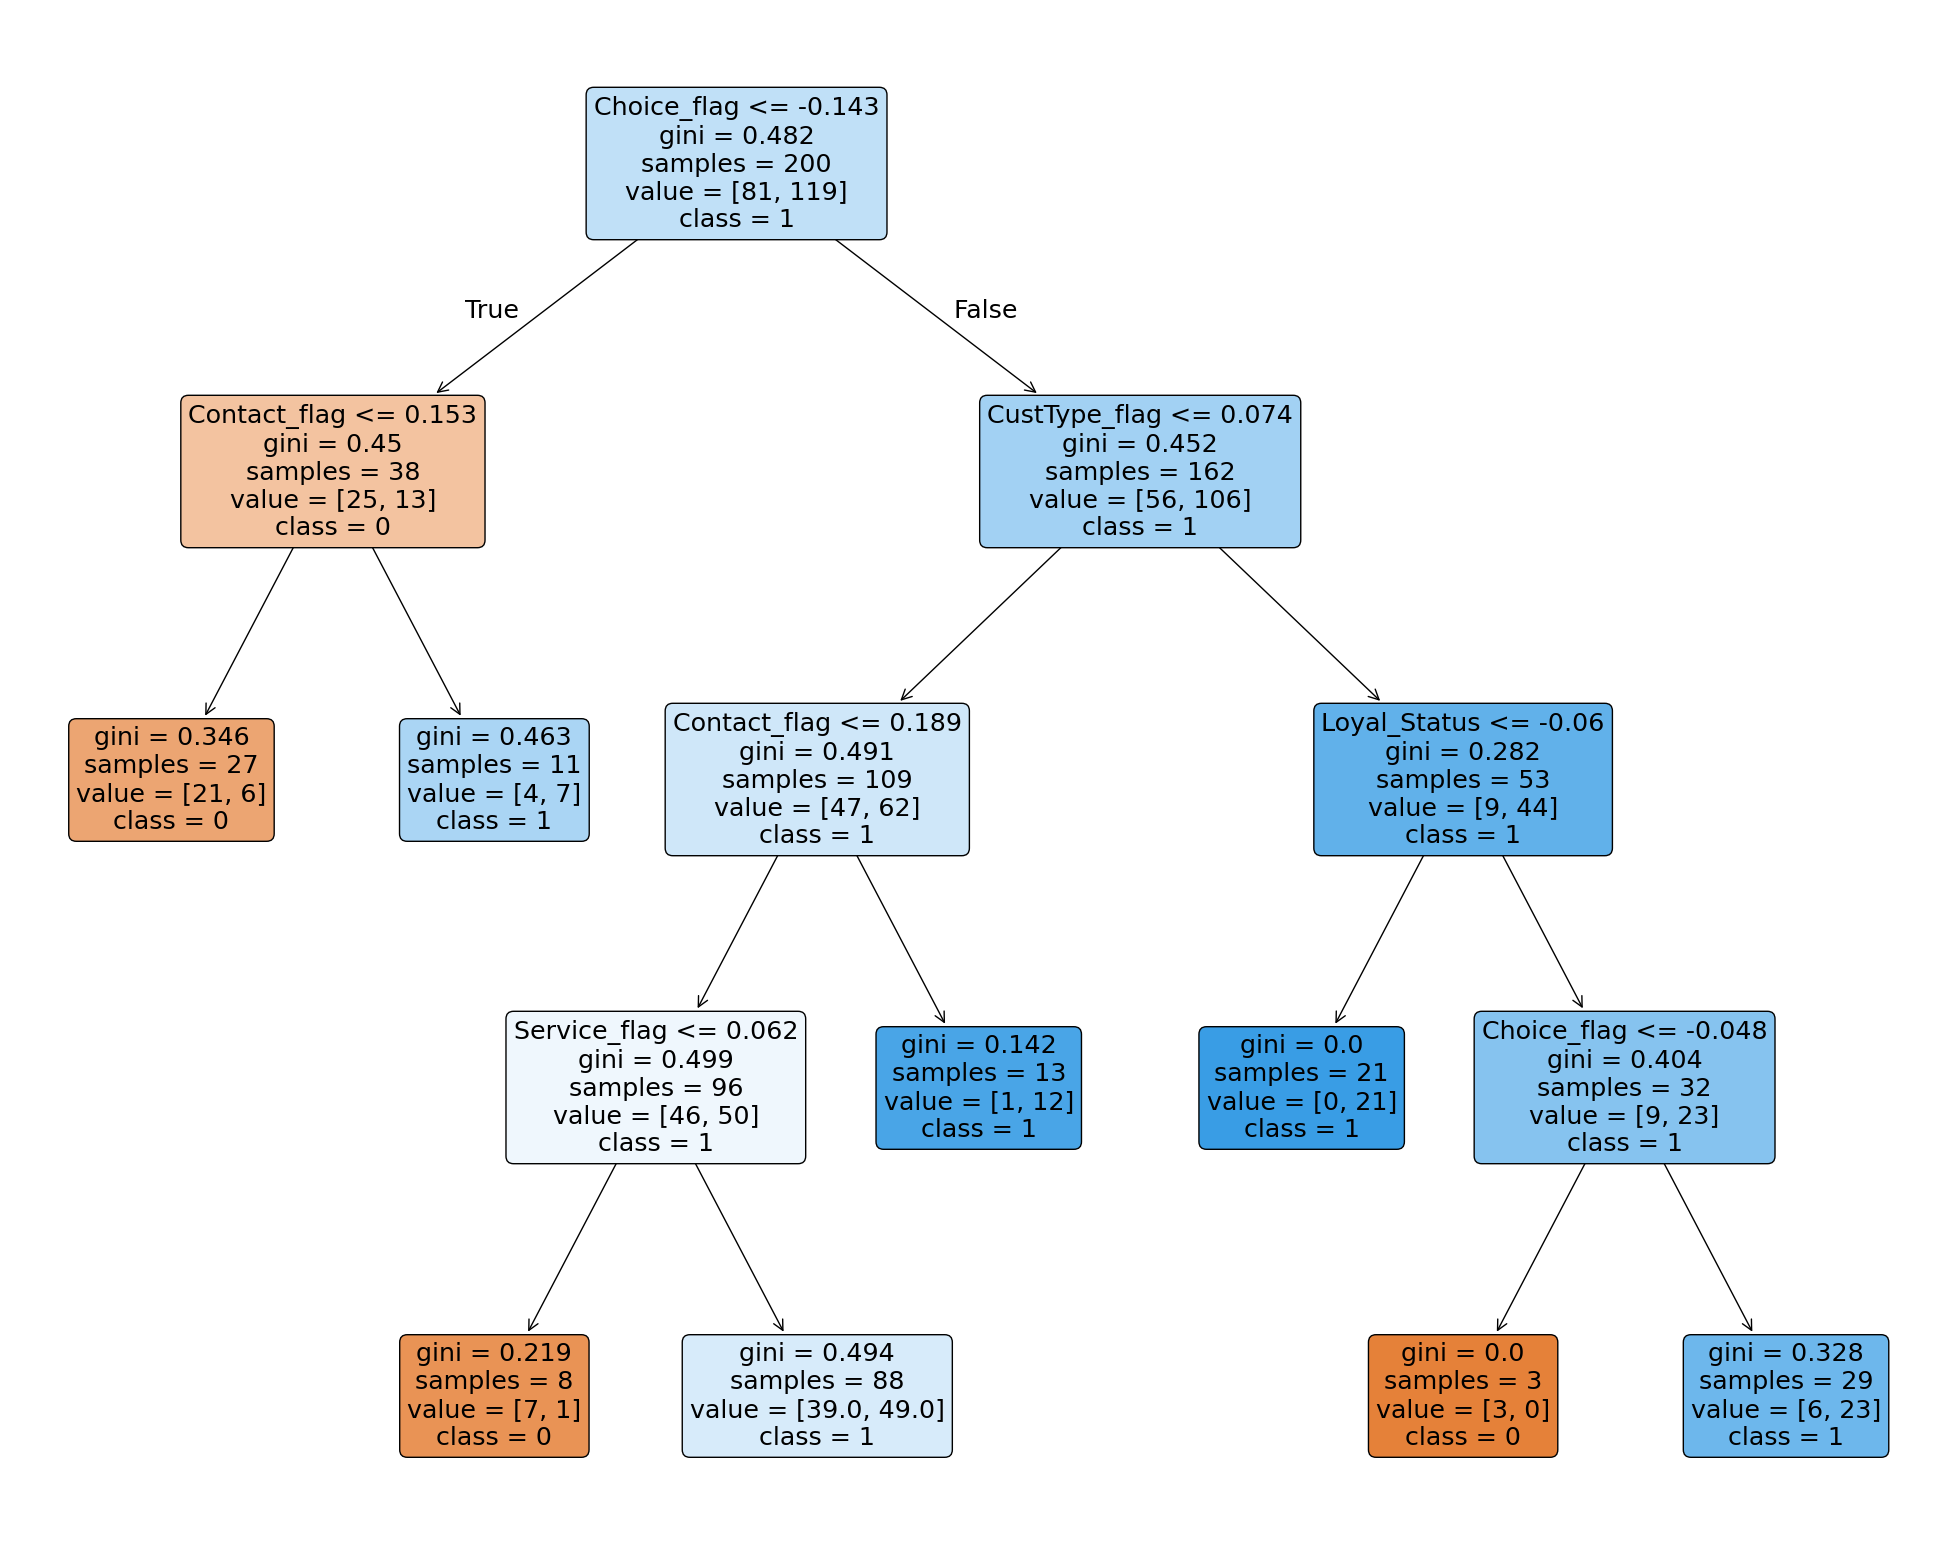

In [22]:
# Display decision tree results

plt.figure(figsize=(25, 20))
tree.plot_tree(
    dtree2,
    feature_names=X_train.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.show()

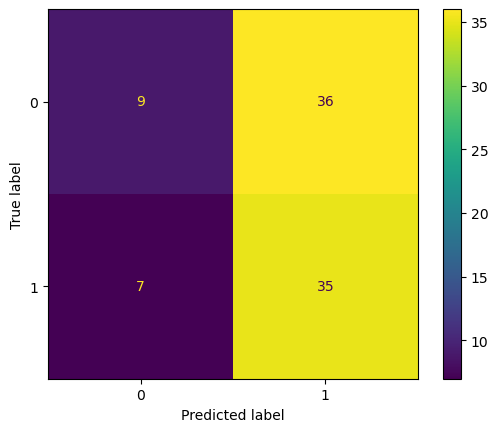

In [21]:
# Confusion Matrix for Hybrid Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred = dtree2.predict(X2_val)
cm = confusion_matrix(y2_val, pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()